In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torch.optim as optim
from sklearn.preprocessing import PolynomialFeatures
from torch.autograd import Variable
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import random_split
from scipy.ndimage import shift
import math
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Create MATRIX data

In [50]:
rows, cols, sigma = 500, 100, 5.0
coefficients1 = [1,4,-4]
coefficients2 = [2,3,1]
degree1 = 2
degree2 = 2

In [51]:
t_values = np.linspace(-10, 10, cols)
shifted_t_values = np.polyval(coefficients1,t_values) #/np.polyval(coefficients2,t_values)

In [5]:
# Gaussian function
def gaussian(x, mu, sigma=1.0):
    return np.exp(-np.power(x - mu, 2.0) / (2 * np.power(sigma, 2.0)))

def create_gaussian_time_matrix(rows=500, cols=50, sigma=1.0):
    matrix = np.zeros((rows, cols))
    for col in range(cols):
        for row in range(rows):
            matrix[row, col] = gaussian(row, rows / 2, sigma)
    matrix /= np.max(matrix)
    
    return matrix


In [6]:
Q_without_shift = create_gaussian_time_matrix(rows, cols, sigma)

In [7]:
def shift_matrix(matrix, shift_vector):
    rows, cols = matrix.shape
    shifted_matrix = np.zeros_like(matrix)

    for col in range(cols):
        shift_val = -shift_vector[col]
        shifted_matrix[:, col] = shift(matrix[:, col], shift_val, mode='nearest')

    return shifted_matrix


In [8]:
Q_with_shift = shift_matrix(Q_without_shift, shifted_t_values)

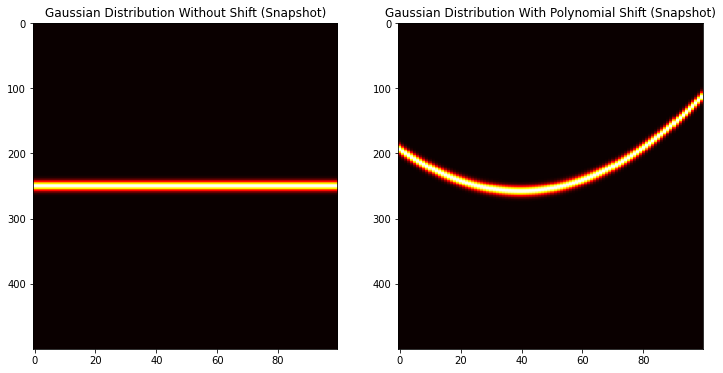

In [9]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Without shift
ax[0].imshow(Q_without_shift, cmap='hot', interpolation='nearest', aspect='auto')
ax[0].set_title('Gaussian Distribution Without Shift (Snapshot)')

# With shift
ax[1].imshow(Q_with_shift, cmap='hot', interpolation='nearest', aspect='auto')
ax[1].set_title('Gaussian Distribution With Polynomial Shift (Snapshot)')

plt.show()

## Generate a data for SIMPLE polynomial regression

In [10]:
print(t_values.shape, shifted_t_values.shape)

(100,) (100,)


In [52]:
np.random.shuffle(t_values)
np.random.seed(42)

train_size = int(cols * 0.8)
val_size = cols - train_size

x_train = t_values[:train_size]
x_val = t_values[train_size:]
y_train = np.polyval(coefficients1,x_train) #/np.polyval(coefficients2,x_train)
y_val = np.polyval(coefficients1,x_val) #/np.polyval(coefficients2,x_val)

In [53]:
x_train = torch.tensor(x_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

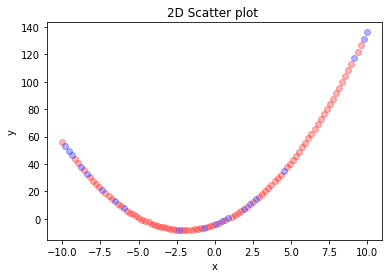

In [54]:
plt.scatter(x_train, y_train, alpha = 0.3, marker = 'o', color = 'r')
plt.scatter(x_val, y_val, alpha = 0.3, marker = 'o', color = 'b')
plt.title('2D Scatter plot ')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## Define a model

In [23]:
class ShiftPredictionModel(nn.Module):
    def __init__(self, degree1, degree2, type_NN):
        super(ShiftPredictionModel, self).__init__()
        self.a_coefficients = nn.ParameterList(
            [nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32)) for _ in range(degree1+1)]
        )
        self.b_coefficients = nn.ParameterList(
            [nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32)) for _ in range(degree2+1)]
        )
        self.type_NN = type_NN
    
    def forward_pol(self,t):
        return sum([coeff * t**i for i, coeff in enumerate(self.a_coefficients)])
    
    def forward_rat(self,t):
        shift2 = sum([coeff * t**i for i, coeff in enumerate(self.b_coefficients)]) + 1e-6 #avoid division by zero
        return self.forward_pol(t)/shift2

    # def forward_activ(self, t):
    #     return F.relu(t)
    
    def forward(self, t):
        if self.type_NN == "polynomial":
            output = self.forward_pol(t)
        elif self.type_NN == "rational":
            output = self.forward_rat(t)
            
        return output

## Train a model

In [24]:
def total_variation(shift):
    return torch.sum(torch.abs(shift[..., 1:] - shift[..., :-1]))

def calculate_loss(true_shift,predicted_shift):
    return torch.max(torch.abs(true_shift - predicted_shift))

In [25]:
model = ShiftPredictionModel(degree1=degree1,degree2=0,type_NN="polynomial") # nn.Linear(40,1)
model.to(torch.float32)

criterion = nn.L1Loss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

# Training the model
epochs = 10000
for epoch in range(epochs):
    
    model.train()
    optimizer.zero_grad()
    y_pred = model(x_train)
    a_coefficients_train = torch.tensor([p.item() for p in model.a_coefficients])
    prediction_loss = criterion(y_pred, y_train)
    #tv_loss=total_variation(predictions)
    loss = prediction_loss #+ 0.5 * tv_loss

    loss.backward()
    optimizer.step()
        
    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred_val = model(x_val)
        #a_coefficients_test = torch.tensor([p.item() for p in model.a_coefficients])
        prediction_val_loss = criterion(y_pred_val,y_val) #calculate_loss(y_val,predictions_val).item()
        #tv_test_loss = total_variation(y_pred_val).item()
        val_loss = prediction_val_loss #+ 0.5 * tv_test_loss
        if epoch % 100 == 0:
            #a_coefficients = [p.item() for p in model.a_coefficients]  # Extract coefficients
            print(f'Epoch [{epoch}/{epochs}], Loss: {loss.item():.4f}, Test Loss: {val_loss:.4f}, Coefficients:{[coefficients1[::-1][i] for i in range(len(coefficients1))]}{a_coefficients_train}')

print(f"Model training complete.")


Epoch [0/10000], Loss: 38.5309, Test Loss: 44.6265, Coefficients:[-4, 4, 1]tensor([-0.5462, -0.0152, -0.2147])
Epoch [100/10000], Loss: 17.7015, Test Loss: 21.8564, Coefficients:[-4, 4, 1]tensor([-0.5436,  0.3627,  0.5923])
Epoch [200/10000], Loss: 15.4611, Test Loss: 19.0283, Coefficients:[-4, 4, 1]tensor([-0.5545,  0.8332,  0.6424])
Epoch [300/10000], Loss: 13.2297, Test Loss: 16.2187, Coefficients:[-4, 4, 1]tensor([-0.5666,  1.3031,  0.6892])
Epoch [400/10000], Loss: 11.0014, Test Loss: 13.4422, Coefficients:[-4, 4, 1]tensor([-0.5787,  1.7725,  0.7381])
Epoch [500/10000], Loss: 8.8045, Test Loss: 10.7226, Coefficients:[-4, 4, 1]tensor([-0.5932,  2.2385,  0.7854])
Epoch [600/10000], Loss: 6.6411, Test Loss: 8.1100, Coefficients:[-4, 4, 1]tensor([-0.6094,  2.7010,  0.8321])
Epoch [700/10000], Loss: 4.5741, Test Loss: 5.7008, Coefficients:[-4, 4, 1]tensor([-0.6295,  3.1528,  0.8788])
Epoch [800/10000], Loss: 2.9076, Test Loss: 3.6093, Coefficients:[-4, 4, 1]tensor([-0.6604,  3.5574,  0

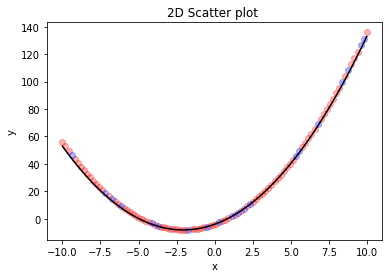

In [26]:
t_values = np.linspace(-10, 10, cols)
y_values = np.polyval(np.flip(a_coefficients_train.numpy()), t_values)

plt.scatter(x_train, y_train, alpha = 0.3, marker = 'o', color = 'r')
plt.scatter(x_val, y_val, alpha = 0.3, marker = 'o', color = 'b')
plt.plot(t_values,y_values, color = 'k')
plt.title('2D Scatter plot ')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [27]:
print(np.linalg.norm(y_val.detach().numpy() - y_pred_val.detach().numpy()) / np.linalg.norm(y_val.detach().numpy()))

0.0023599083
